In [1]:
%load_ext autoreload  
%autoreload 2   

In [85]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

from dataset import UnemployRateDataset, extract_data
from model import HybridLSTMGRU
import evaluation as eval

# Chômage

Dataset extrait chômage :

- Date : 1983-01 à 2024-12
- Zone : France, USA, United Kingdom, Italie
- Mesure: Taux de chomage mensuel
- Unité: Pourcentage de la population active 
- Ajustemenet : corrigé des variations saisonieres, et des effets de calendrier (data_ocde_corr)
- Sexe: Tout 
- Age: 15 ans et plus 

In [83]:
dataset = pd.read_csv("data_ocde_cor.csv", usecols=["TIME_PERIOD",'REF_AREA', "OBS_VALUE"])

pays_avaliable = dataset["REF_AREA"].unique()
pays = "FRA"
dataset

,REF_AREA,TIME_PERIOD,OBS_VALUE
0,USA,2013-08,7.2
1,USA,2013-09,7.2
2,ITA,2002-07,8.6
3,ITA,2002-08,8.6
4,ITA,2002-09,8.6
...,...,...,...
2011,USA,2024-09,4.1
2012,USA,2024-10,4.1
2013,USA,2024-11,4.2
2014,USA,2024-12,4.1


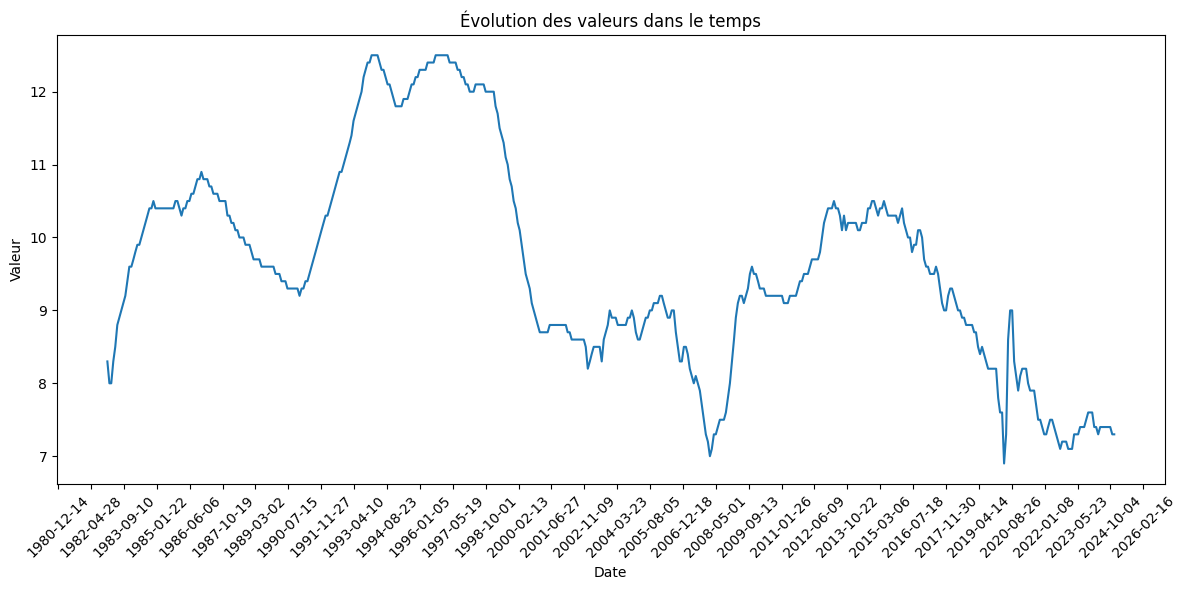

In [84]:
dataset_FRA = dataset[dataset["REF_AREA"] == pays]
dataset_FRA.loc[:, 'TIME_PERIOD'] = pd.to_datetime(dataset_FRA["TIME_PERIOD"])
dataset_FRA = dataset_FRA.sort_values(by='TIME_PERIOD')

plt.figure(figsize=(12, 6))
plt.plot(dataset_FRA['TIME_PERIOD'], dataset_FRA['OBS_VALUE'])
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Évolution des valeurs dans le temps')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

# Split Training/Test

In [ ]:
from torch.utils.data import DataLoader

pays = "FRA"
prop = [0.7, 0.15, 0.15]
scaler=MinMaxScaler()
seq_len = 6
shift = 1

train_data, val_data, test_data = extract_data(dataset, pays, prop, scaler=scaler)
dataset_train = UnemployRateDataset(train_data, seq_len=seq_len, shift=shift)
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [ ]:
from torch import nn
import torch.optim as optim
import train_plot

DEVICE = "cuda"

model = HybridLSTMGRU().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 1500
train_plot.metric_start_plot()
for epoch in range(EPOCHS):
    model.train()
    for X, y in train_dataloader:
        X = X.unsqueeze(-1).to(DEVICE)
        y = y.unsqueeze(-1).to(DEVICE)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
    if (epoch-1) % 100 == 0:
        #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
        train_rmse, train_mae, train_mape = eval.evaluate(model, train_data, None, seq_len, scaler)
        val_rmse, val_mae, val_mape = eval.evaluate(model, val_data, train_data, seq_len, scaler)
        print(f"Epoch {epoch}/{EPOCHS}")
        print(f"Training - RMSE: {train_rmse:.4f},  MAE: {train_mae:.4f}, MAPE: {train_mape:.4f}")
        print(f"Validation - RMSE: {val_rmse:.4f},  MAE: {val_mae:.4f}, MAPE: {val_mape:.4f}")
    
train_plot.metric_end_plot()

Epoch 1/1500
Training - RMSE: 1.2417,  MAE: 0.9918, MAPE: 0.0966
Validation - RMSE: 0.4873,  MAE: 0.4390, MAPE: 0.0438
Epoch 101/1500
Training - RMSE: 0.1194,  MAE: 0.0926, MAPE: 0.0097
Validation - RMSE: 0.1555,  MAE: 0.1274, MAPE: 0.0129
Epoch 201/1500
Training - RMSE: 0.0869,  MAE: 0.0634, MAPE: 0.0067
Validation - RMSE: 0.1184,  MAE: 0.0948, MAPE: 0.0096
Epoch 301/1500
Training - RMSE: 0.0805,  MAE: 0.0601, MAPE: 0.0063
Validation - RMSE: 0.1119,  MAE: 0.0885, MAPE: 0.0089
Epoch 401/1500
Training - RMSE: 0.0796,  MAE: 0.0603, MAPE: 0.0063
Validation - RMSE: 0.1107,  MAE: 0.0877, MAPE: 0.0088
Epoch 501/1500
Training - RMSE: 0.0819,  MAE: 0.0636, MAPE: 0.0067
Validation - RMSE: 0.1123,  MAE: 0.0888, MAPE: 0.0089
Epoch 601/1500
Training - RMSE: 0.0800,  MAE: 0.0587, MAPE: 0.0062
Validation - RMSE: 0.1117,  MAE: 0.0886, MAPE: 0.0089
Epoch 701/1500
Training - RMSE: 0.0803,  MAE: 0.0605, MAPE: 0.0063
Validation - RMSE: 0.1114,  MAE: 0.0885, MAPE: 0.0089
Epoch 801/1500
Training - RMSE: 0.

Test - RMSE: 1.4761,  MAE: 0.7539, MAPE: 0.1367
Naive - RMSE: 1.2721,  MAE: 0.3526, MAPE: 0.0464


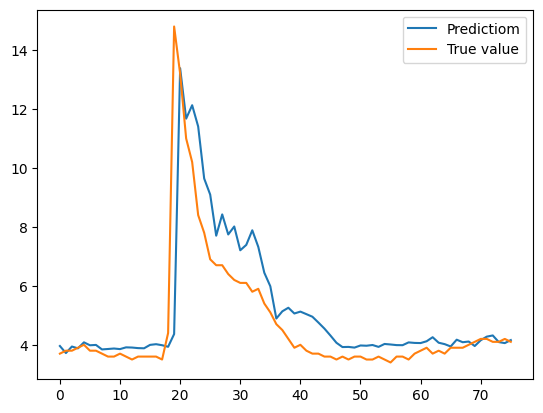

In [ ]:

test_rmse, test_mae, test_mape = eval.evaluate(model, test_data, val_data, seq_len, scaler)
naive_rmse, naive_mae, naive_mape = eval.evaluate_naive(test_data, val_data, seq_len, scaler)

print(f"Test - RMSE: {test_rmse:.4f},  MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}")
print(f"Naive - RMSE: {naive_rmse:.4f},  MAE: {naive_mae:.4f}, MAPE: {naive_mape:.4f}")

eval.plot_prediction(model, test_data, val_data, seq_len, scaler)


# Températures

#### Modèle construit pour Paris

#### 1500 epochs pas besoin de tester les autres, on explique c'est le meilleur et donc on ne test pas cet hyperparamètre

#### On test différentes longueurs de séquence (Nombre de points utilisés pour prédire prochain point) et différentes batch size (Plusieurs longueurs séquence peu de batch size) avec la longueur testée en premier avec une batch size fixed et ensuite on test la meilleure batch size pour cette longueur

#### 3 à 24 mois pour les longueurs de séquence testéss

#### Comparer les résultats entre les modèles testé et parler du meilleur modèle

#### Comparer meilleur modèle température vs chômage. Est-ce le même et est-ce qu'il performe mieux sur un type de données

#### Parler qu'un modèle naïf est meilleur

#### Potentiellement voir si le meilleur modèle change pour différents pays et si meilleures performances ou si toujours naïf le meilleur

## TODO
### Désaisonnaliser
### Refaire graphique

In [70]:
dataset_temp = pd.read_csv("city_temperature.csv", usecols=["Year", 'Month', 'Day', 'Country', 'City', 'AvgTemperature'])
dataset_temp

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...
2906322,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,US,San Juan Puerto Rico,7,30,2013,83.8


In [71]:
# Puisqu'il y a des valeurs de -99 Farenheit pour certaines journnées, on peut assumer que celles-ci sont le résultat de valeurs manquantes
# On peut donc enlever ces valeurs de l'ensemble de données

dataset_temp = dataset_temp[dataset_temp['AvgTemperature'] > 0].reset_index(drop=True)
dataset_temp

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...
2815912,US,San Juan Puerto Rico,7,27,2013,82.4
2815913,US,San Juan Puerto Rico,7,28,2013,81.6
2815914,US,San Juan Puerto Rico,7,29,2013,84.2
2815915,US,San Juan Puerto Rico,7,30,2013,83.8


In [72]:
# Par la suite, on transforme les données pour avoir une moyenne des températures à chaque mois plutôt qu'à chaque année

dataset_temp_mensuel = dataset_temp.groupby(['Country', 'City', 'Year', 'Month'])['AvgTemperature'].mean().reset_index()
dataset_temp_mensuel

,Country,City,Year,Month,AvgTemperature
0,Albania,Tirana,1997,4,58.340000
1,Albania,Tirana,1997,5,67.233333
2,Albania,Tirana,1997,6,77.366667
3,Albania,Tirana,1997,7,80.811111
4,Albania,Tirana,1998,2,47.800000
...,...,...,...,...,...
92898,Zambia,Lusaka,2013,9,71.777778
92899,Zambia,Lusaka,2013,10,78.150000
92900,Zambia,Lusaka,2013,11,77.838095
92901,Zambia,Lusaka,2013,12,74.086364


In [73]:
dataset_temp_mensuel['Time Period'] = dataset_temp_mensuel['Year'].astype(str) + '-' + dataset_temp_mensuel['Month'].astype(str)
dataset_temp_mensuel.loc[:, 'Time Period'] = pd.to_datetime(dataset_temp_mensuel['Time Period']).dt.date
dataset_temp_mensuel

,Country,City,Year,Month,AvgTemperature,Time Period
0,Albania,Tirana,1997,4,58.340000,1997-04-01
1,Albania,Tirana,1997,5,67.233333,1997-05-01
2,Albania,Tirana,1997,6,77.366667,1997-06-01
3,Albania,Tirana,1997,7,80.811111,1997-07-01
4,Albania,Tirana,1998,2,47.800000,1998-02-01
...,...,...,...,...,...,...
92898,Zambia,Lusaka,2013,9,71.777778,2013-09-01
92899,Zambia,Lusaka,2013,10,78.150000,2013-10-01
92900,Zambia,Lusaka,2013,11,77.838095,2013-11-01
92901,Zambia,Lusaka,2013,12,74.086364,2013-12-01


In [75]:
# On fait le modèle pour les températures moyennes par mois à Paris en France

pays = 'France'
ville = 'Paris'

dataset_temp_mensuel_Paris = dataset_temp_mensuel[(dataset_temp_mensuel["City"] == ville) & (dataset_temp_mensuel["Country"] == pays)].reset_index(drop=True)
dataset_temp_mensuel_Paris = dataset_temp_mensuel_Paris.sort_values(by='Time Period')
dataset_temp_mensuel_Paris

,Country,City,Year,Month,AvgTemperature,Time Period
0,France,Paris,1995,1,42.158065,1995-01-01
1,France,Paris,1995,2,48.160714,1995-02-01
2,France,Paris,1995,3,45.938710,1995-03-01
3,France,Paris,1995,4,51.226667,1995-04-01
4,France,Paris,1995,5,60.041935,1995-05-01
...,...,...,...,...,...,...
300,France,Paris,2020,1,43.432258,2020-01-01
301,France,Paris,2020,2,47.441379,2020-02-01
302,France,Paris,2020,3,47.103226,2020-03-01
303,France,Paris,2020,4,57.176667,2020-04-01


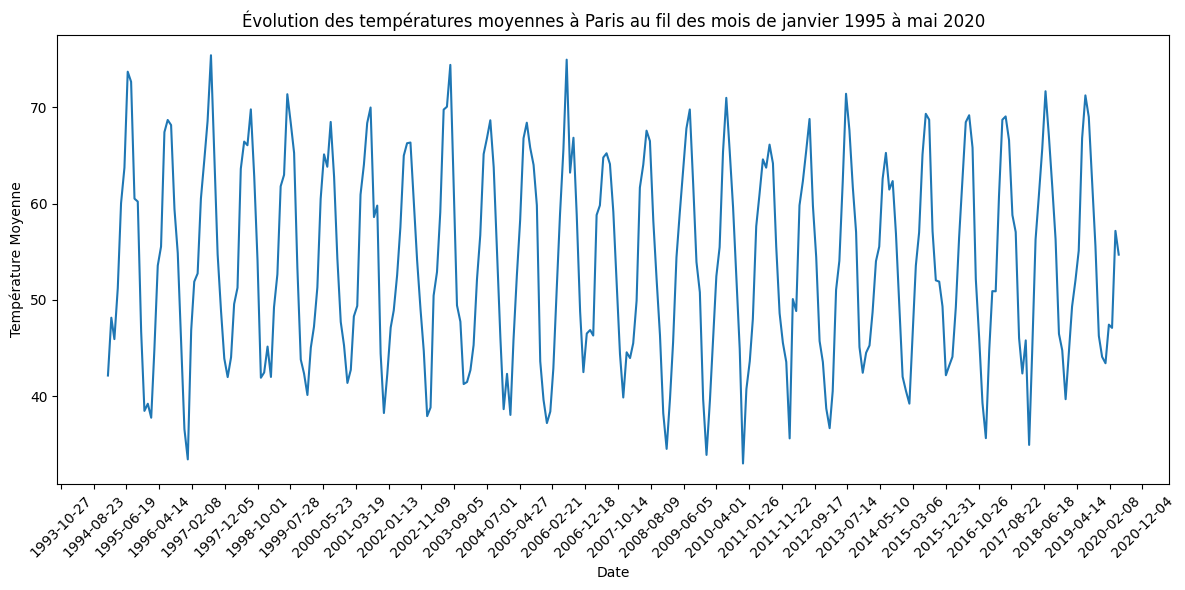

In [80]:
# On visualise la série chronologique

plt.figure(figsize=(12, 6))
plt.plot(dataset_temp_mensuel_Paris['Time Period'], dataset_temp_mensuel_Paris['AvgTemperature'])
plt.xlabel('Date')
plt.ylabel('Température Moyenne')
plt.title('Évolution des températures moyennes à Paris au fil des mois de janvier 1995 à mai 2020')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

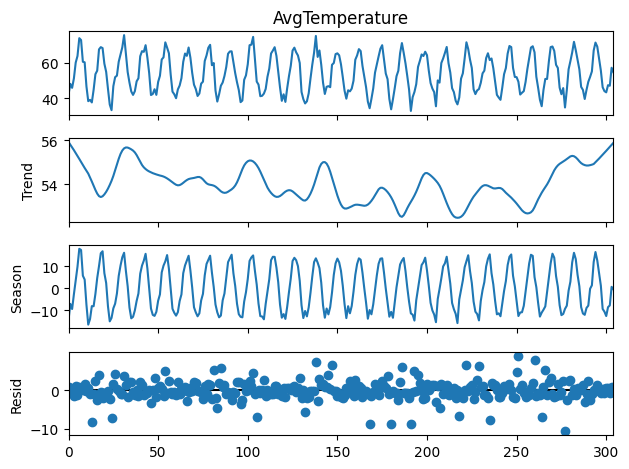

In [ ]:
# Comme les données du chômage étaient désaisonnalisées, on effectue le même traitement pour ces données qui ont clairement une saisonnalité
# sur les 12 mois de l'année

stl = STL(dataset_temp_mensuel_Paris['AvgTemperature'], period = 12, robust = True)
res = stl.fit()

dataset_temp_mensuel_Paris['Saisonnalité'] = res.seasonal
dataset_temp_mensuel_Paris['AvgTemperature Adjusted'] = dataset_temp_mensuel_Paris['AvgTemperature'] - dataset_temp_mensuel_Paris['Saisonnalité']

res.plot()
plt.show()